# ThinkDSP

This notebook contains solutions to exercises in Chapter 9: Differentiation and Integration

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [22]:
%matplotlib inline

import thinkdsp
import thinkplot
import thinkstats2

import numpy as np
import pandas as pd
import scipy.signal

# suppress division by zero warning
from warnings import simplefilter
simplefilter('ignore', RuntimeWarning)

PI2 = 2 * np.pi
GRAY = '0.7'

**Exercise:** In the section on cumulative sum, I mentioned that some of the examples don't work with non-periodic signals.  Try replacing the sawtooth wave, which is periodic, with the Facebook stock price data, which is not, and see what goes wrong.

*Solution:* I'll start by loading the Facebook data again.

In [4]:
names = ['date', 'open', 'high', 'low', 'close', 'volume']
df = pd.read_csv('fb.csv', header=0, names=names, parse_dates=[0])
ys = df.close.values[::-1]

And making a Wave

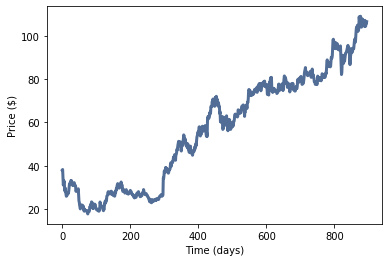

In [5]:
close = thinkdsp.Wave(ys, framerate=1)
close.plot()
thinkplot.config(xlabel='Time (days)', ylabel='Price ($)')

I'll compute the daily changes using `Wave.diff`:

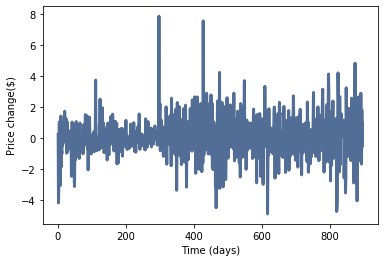

In [6]:
change = close.diff()
change.plot()
thinkplot.config(xlabel='Time (days)', ylabel='Price change($)')

Now I'll run the `cumsum` example using `change` as the input wave:

In [7]:
in_wave = change

Here's the spectrum before the cumulative sum:

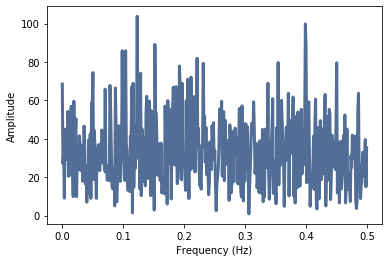

In [8]:
in_spectrum = in_wave.make_spectrum()
in_spectrum.plot()
thinkplot.config(xlabel='Frequency (Hz)',
                 ylabel='Amplitude')

The output wave is the cumulative sum of the input

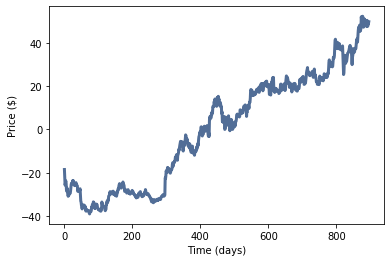

In [9]:
out_wave = in_wave.cumsum()
out_wave.unbias()
out_wave.plot()
thinkplot.config(xlabel='Time (days)', ylabel='Price ($)')

And here's its spectrum

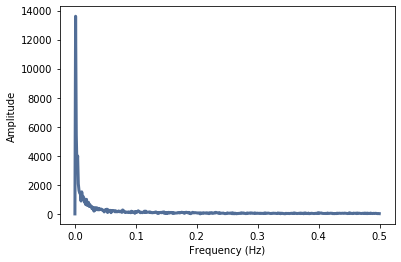

In [10]:
out_spectrum = out_wave.make_spectrum()
out_spectrum.plot()
thinkplot.config(xlabel='Frequency (Hz)',
                 ylabel='Amplitude')

Now we compute the ratio of the output to the input:

In [11]:
sum(in_spectrum.amps < 10), len(in_spectrum)

(37, 448)

In between the harmonics, the input componenents are small, so I set those ratios to NaN.

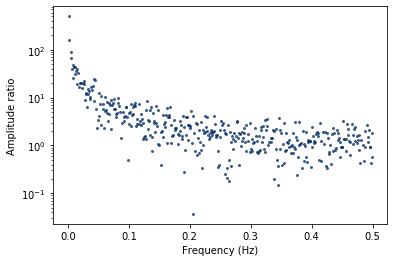

In [12]:
ratio_spectrum = out_spectrum.ratio(in_spectrum, thresh=10)
ratio_spectrum.hs[0] = 0
ratio_spectrum.plot(style='.', markersize=4)

thinkplot.config(xlabel='Frequency (Hz)',
                 ylabel='Amplitude ratio',
                 yscale='log')

Instead of falling in a neat line, the ratios are pretty noisy.

We can compare them with the cumsum filter:

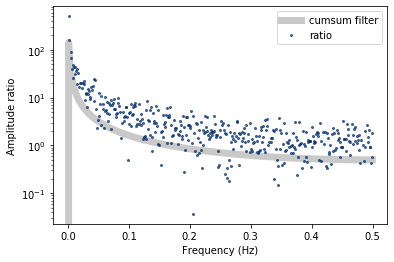

In [13]:
diff_window = np.array([1.0, -1.0])
padded = thinkdsp.zero_pad(diff_window, len(in_wave))
diff_wave = thinkdsp.Wave(padded, framerate=in_wave.framerate)
diff_filter = diff_wave.make_spectrum()

cumsum_filter = diff_filter.copy()
cumsum_filter.hs = 1 / cumsum_filter.hs
cumsum_filter.hs[0] = 0
cumsum_filter.plot(label='cumsum filter', color=GRAY, linewidth=7)

ratio_spectrum.plot(label='ratio', style='.', markersize=4)
thinkplot.config(xlabel='Frequency (Hz)',
                 ylabel='Amplitude ratio',
                 yscale='log', legend=True)

The ratios follow the general shape of the filter, but they are not in accord.

Now we can compute the output wave using the convolution theorem, and compare the results:

In [14]:
len(in_spectrum), len(cumsum_filter)

(448, 448)

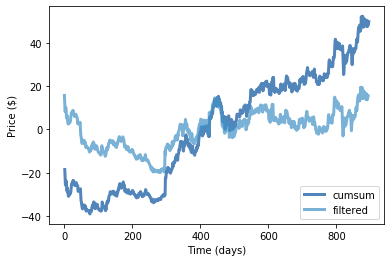

In [15]:
thinkplot.preplot(2)

out_wave.plot(label='cumsum')

in_spectrum = in_wave.make_spectrum()
out_wave2 = (in_spectrum * cumsum_filter).make_wave()
out_wave2.plot(label='filtered')

thinkplot.config(legend=True, loc='lower right')
thinkplot.config(xlabel='Time (days)', ylabel='Price ($)')

They are clearly different.

**Exercise:** The goal of this exercise is to explore the effect of `diff` and `differentiate` on a signal.  Create a triangle wave and plot it.  Apply the `diff` operator and plot the result.  Compute the spectrum of the triangle wave, apply `differentiate`, and plot the result.  Convert the spectrum back to a wave and plot it.  Are there differences between the effect of `diff` and `differentiate` for this wave?

*Solution:* Here's the triangle wave.

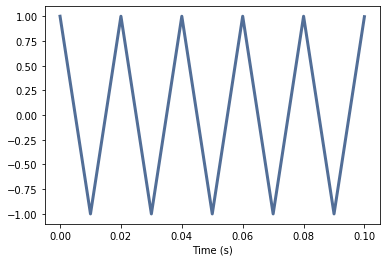

In [16]:
in_wave = thinkdsp.TriangleSignal(freq=50).make_wave(duration=0.1, framerate=44100)
in_wave.plot()
thinkplot.config(xlabel='Time (s)')

The diff of a triangle wave is a square wave, which explains why the harmonics in a square wave drop off like $1/f$, compared to the triangle wave, which drops off like $1/f^2$.

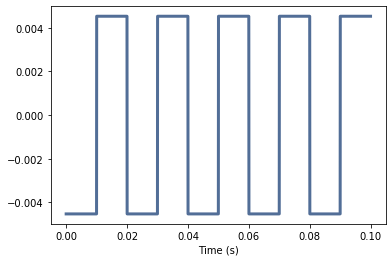

In [17]:
out_wave = in_wave.diff()
out_wave.plot()
thinkplot.config(xlabel='Time (s)')

When we take the spectral derivative, we get "ringing" around the discontinuities: https://en.wikipedia.org/wiki/Ringing_(signal)

Mathematically speaking, the problem is that the derivative of the triangle wave is undefined at the points of the triangle.

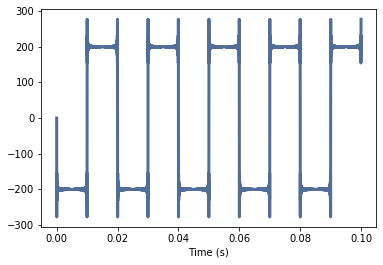

In [18]:
out_wave2 = in_wave.make_spectrum().differentiate().make_wave()
out_wave2.plot()
thinkplot.config(xlabel='Time (s)')

**Exercise:** The goal of this exercise is to explore the effect of `cumsum` and `integrate` on a signal.  Create a square wave and plot it.  Apply the `cumsum` operator and plot the result.  Compute the spectrum of the square wave, apply `integrate`, and plot the result.  Convert the spectrum back to a wave and plot it.  Are there differences between the effect of `cumsum` and `integrate` for this wave?

*Solution:* Here's the square wave.

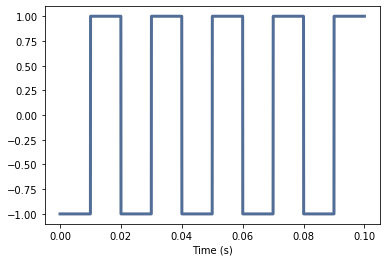

In [19]:
in_wave = thinkdsp.SquareSignal(freq=50).make_wave(duration=0.1, framerate=44100)
in_wave.plot()
thinkplot.config(xlabel='Time (s)')

The cumulative sum of a square wave is a triangle wave.  After the previous exercise, that should come as no surprise.

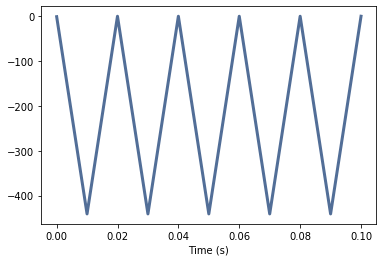

In [20]:
out_wave = in_wave.cumsum()
out_wave.plot()
thinkplot.config(xlabel='Time (s)')

The spectral integral is also a triangle wave, although the amplitude is very different.

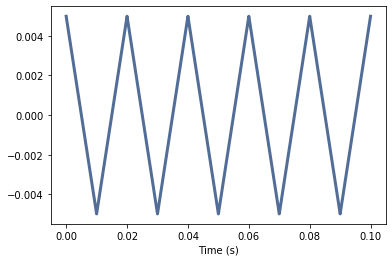

In [23]:
spectrum = in_wave.make_spectrum().integrate()
spectrum.hs[0] = 0
out_wave2 = spectrum.make_wave()
out_wave2.plot()
thinkplot.config(xlabel='Time (s)')

If we unbias and normalize the two waves, they are visually similar.

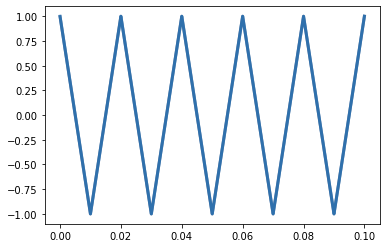

In [24]:
out_wave.unbias()
out_wave.normalize()
out_wave2.normalize()
out_wave.plot()
out_wave2.plot()

And they are numerically similar, but with only about 3 digits of precision.

In [25]:
max(abs(out_wave.ys - out_wave2.ys))

0.0045351473922902175

**Exercise:** The goal of this exercise is the explore the effect of integrating twice.  Create a sawtooth wave, compute its spectrum, then apply `integrate` twice.  Plot the resulting wave and its spectrum.  What is the mathematical form of the wave?  Why does it resemble a sinusoid? 

Here's the sawtooth.

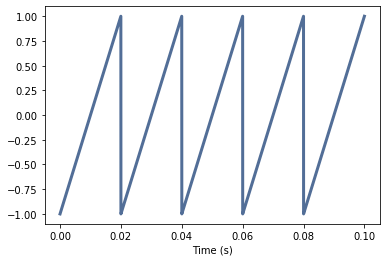

In [26]:
in_wave = thinkdsp.SawtoothSignal(freq=50).make_wave(duration=0.1, framerate=44100)
in_wave.plot()
thinkplot.config(xlabel='Time (s)')

The first cumulative sum of a sawtooth is a parabola:

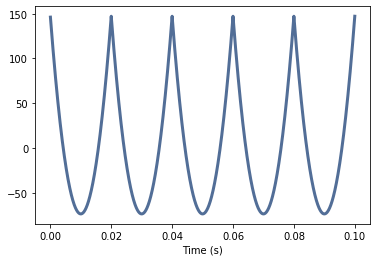

In [27]:
out_wave = in_wave.cumsum()
out_wave.unbias()
out_wave.plot()
thinkplot.config(xlabel='Time (s)')

The second cumulative sum is a cubic curve:

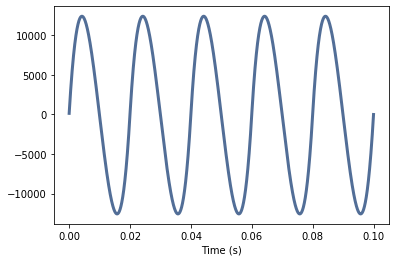

In [28]:
out_wave = out_wave.cumsum()
out_wave.plot()
thinkplot.config(xlabel='Time (s)')

Integrating twice also yields a cubic curve.

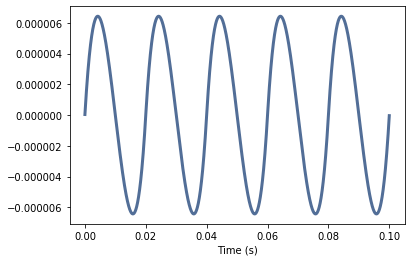

In [29]:
spectrum = in_wave.make_spectrum().integrate().integrate()
spectrum.hs[0] = 0
out_wave2 = spectrum.make_wave()
out_wave2.plot()
thinkplot.config(xlabel='Time (s)')

At this point, the result looks more and more like a sinusoid.  The reason is that integration acts like a low pass filter.  At this point we have filtered out almost everything except the fundamental, as shown in the spectrum below:

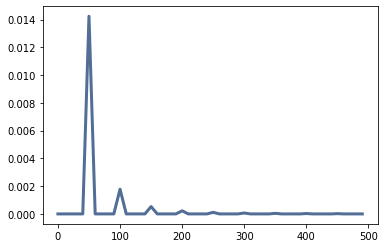

In [30]:
out_wave2.make_spectrum().plot(high=500)

**Exercise:** The goal of this exercise is to explore the effect of the 2nd difference and 2nd derivative.  Create a `CubicSignal`, which is defined in `thinkdsp`.  Compute the second difference by applying `diff` twice.  What does the result look like.  Compute the second derivative by applying `differentiate` twice.  Does the result look the same?

Plot the filters that corresponds to the 2nd difference and the 2nd derivative and compare them.  Hint: In order to get the filters on the same scale, use a wave with framerate 1.

*Solution:* Here's the cubic signal

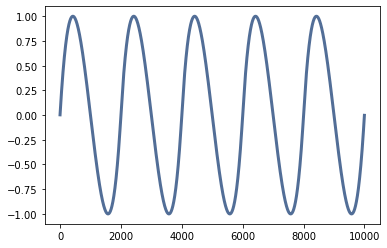

In [31]:
in_wave = thinkdsp.CubicSignal(freq=0.0005).make_wave(duration=10000, framerate=1)
in_wave.plot()

The first difference is a parabola and the second difference is a sawtooth wave (no surprises so far):

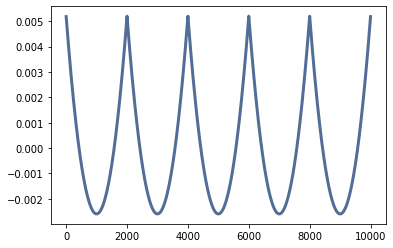

In [32]:
out_wave = in_wave.diff()
out_wave.plot()

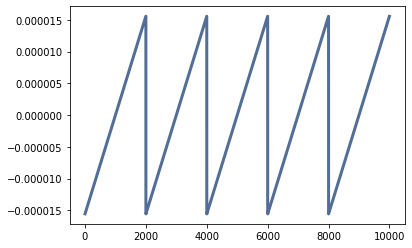

In [33]:
out_wave = out_wave.diff()
out_wave.plot()

When we differentiate twice, we get a sawtooth with some ringing.  Again, the problem is that the deriviative of the parabolic signal is undefined at the points.

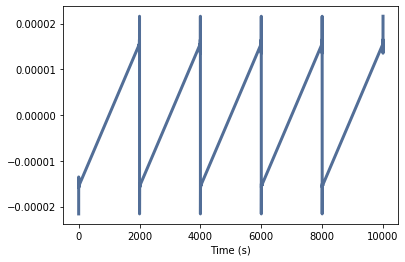

In [34]:
spectrum = in_wave.make_spectrum().differentiate().differentiate()
out_wave2 = spectrum.make_wave()
out_wave2.plot()
thinkplot.config(xlabel='Time (s)')

The window of the second difference is -1, 2, -1.  By computing the DFT of the window, we can find the corresponding filter.

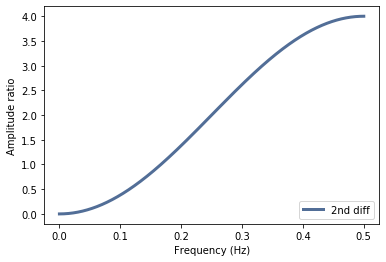

In [35]:
diff_window = np.array([-1.0, 2.0, -1.0])
padded = thinkdsp.zero_pad(diff_window, len(in_wave))
diff_wave = thinkdsp.Wave(padded, framerate=in_wave.framerate)
diff_filter = diff_wave.make_spectrum()
diff_filter.plot(label='2nd diff')

thinkplot.config(xlabel='Frequency (Hz)',
                 ylabel='Amplitude ratio',
                 legend=True, loc='lower right')

And for the second derivative, we can find the corresponding filter by computing the filter of the first derivative and squaring it.

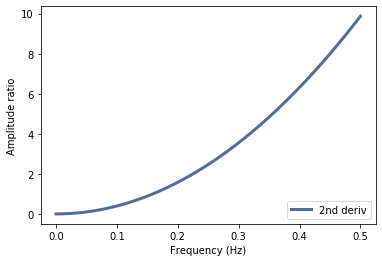

In [36]:
deriv_filter = in_wave.make_spectrum()
deriv_filter.hs = (PI2 * 1j * deriv_filter.fs)**2
deriv_filter.plot(label='2nd deriv')

thinkplot.config(xlabel='Frequency (Hz)',
                 ylabel='Amplitude ratio',
                 legend=True, loc='lower right')

Here's what the two filters look like on the same scale:

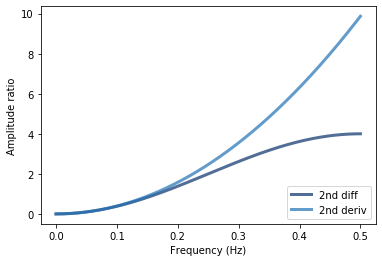

In [37]:
diff_filter.plot(label='2nd diff')
deriv_filter.plot(label='2nd deriv')

thinkplot.config(xlabel='Frequency (Hz)',
                 ylabel='Amplitude ratio',
                 legend=True, loc='lower right')

Both are high pass filters that amplify the highest frequency components.  The 2nd derivative is parabolic, so it amplifies the highest frequencies the most.  The 2nd difference is a good approximation of the 2nd derivative only at the lowest frequencies, then it deviates substantially.